In [1]:
import itertools
import functools

import numpy as np
import pandas as pd

import networkx as nx
import pydot
from networkx.drawing.nx_pydot import graphviz_layout
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

from tqdm import tqdm

import sdnist

In [2]:
import importlib
importlib.reload(sdnist)

<module 'sdnist' from '/Users/gregoirelothe/Documents/Sarus/code/synthetic-data-challenges/sdnist/__init__.py'>

## 1. Load both the public & the private dataset

In [3]:
public, schema = sdnist.census(public=True)

public

,PUMA,YEAR,HHWT,GQ,PERWT,SEX,AGE,MARST,RACE,HISPAN,...,WORKEDYR,INCTOT,INCWAGE,INCWELFR,INCINVST,INCEARN,POVERTY,DEPARTS,ARRIVES,sim_individual_id
0,17-1001,2012,88.0,1,61.0,1,21,6,1,0,...,3,14000,14000,0,0,14000,118,902,909,12
1,17-1001,2012,61.0,1,85.0,1,21,6,1,0,...,3,18000,0,0,0,18000,262,732,744,33
2,17-1001,2012,54.0,1,54.0,1,21,6,1,0,...,3,14000,14000,0,0,14000,118,642,654,401
3,17-1001,2012,106.0,1,69.0,1,21,6,1,0,...,3,3800,3800,0,0,3800,262,0,0,470
4,17-1001,2012,31.0,1,56.0,1,21,6,1,0,...,3,14000,14000,0,0,14000,501,0,0,702
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1035196,39-4300,2018,103.0,1,90.0,2,37,1,9,0,...,3,36000,36000,0,0,36000,231,1605,1624,556291
1035197,39-4106,2018,207.0,1,207.0,2,41,6,9,0,...,3,52800,52000,0,0,52000,361,1005,1019,1139708
1035198,17-2200,2018,73.0,1,58.0,2,46,4,9,0,...,2,25800,0,0,0,0,200,0,0,346052
1035199,17-2300,2018,47.0,1,47.0,2,46,1,9,0,...,3,5000,5000,0,0,5000,399,732,754,40265


## 2. Subsampling 

As a warm-up, we compute the score of subsampled dataset.

### 2.1 Naive subsampling

In [4]:
# Randomly select rows
synthetic = public.sample(frac=0.02)

# Compute longitudinal score
score = sdnist.kmarginal.CensusLongitudinalKMarginalScore(public, synthetic)
score.compute_score()

  8%|███▌                                       | 25/300 [00:00<00:02, 116.53it/s]/opt/homebrew/Caskroom/miniforge/base/envs/py39/lib/python3.9/site-packages/pandas/core/indexes/multi.py:3554: RuntimeWarning: The values in the array are unorderable. Pass `sort=False` to suppress this warning.
  result = lib.fast_unique_multiple([self._values, rvals], sort=sort)
100%|██████████████████████████████████████████| 300/300 [00:02<00:00, 104.17it/s]


135.37621976379612

### 2.2 User-level subsampling

In [5]:
# Build flat dataset
public_flat = sdnist.utils.unstack(public)

# Randomly sample individuals
synthetic_flat = public_flat.sample(frac=0.1)

# Reset into original format
synthetic = sdnist.utils.stack(synthetic_flat)

# Compute score
score = sdnist.kmarginal.CensusLongitudinalKMarginalScore(public, synthetic)
score.compute_score()

100%|██████████████████████████████████████████| 300/300 [00:02<00:00, 104.15it/s]


948.6686829496338

## 3. First order bayesian network ($k=1$)

As described in *PrivBayes: Private Data Release via Bayesian Networks* (http://dimacs.rutgers.edu/~graham/pubs/papers/PrivBayes.pdf), except that we compute the tree structure on a public dataset.


### 3.1 Building the Chow-Liu tree structure from the public dataset

We represent the joint distribution as a first order bayesian network. The dependency tree is constructed from the public dataset.

We only allow a column to depend on the current or the previous year.

In [6]:
public_bin = sdnist.utils.discretize(public, sdnist.kmarginal.CensusKMarginalScore.BINS)
public_flat = sdnist.utils.unstack(public_bin)
n = len(public_flat)

def mutual_information(df, col_a, col_b):
    ab = df.groupby([*col_a, col_b]).size().unstack(col_b, fill_value=0).to_numpy() / n
    a = ab.sum(axis=0, keepdims=True)
    b = ab.sum(axis=1, keepdims=True)
    
    llr = np.zeros_like(ab)
    np.log(ab / (a * b), where=ab > 0, out=llr)
    return np.sum(ab * llr)

def greedy_bayes(df, root = ("PUMA", 2012), order=1):
    # Graph : for vizualization purposes
    graph = nx.DiGraph()
    graph.add_node(root)
    
    # Conditional distribution in topological order
    cond = [(root,)]

    # Greedy algorithm
    remaining = list(sorted(df.columns, key=lambda c: c[1]))
    remaining.remove(root)
    
    mutual_information_memoize = functools.cache(functools.partial(mutual_information, df))
    
    for i in tqdm(range(len(df.columns)-1)):
        max_col = None
        max_parents = None
        max_mi = 0
        
        for col in remaining:
            # col[1] : YEAR
            if col[1] != remaining[0][1]:
                continue
            
            for parents in itertools.combinations(graph.nodes, r=min(len(graph.nodes), order)):
                if parents[0][1] < col[1] - 1:
                    continue
                
                mi = mutual_information_memoize(parents, col)
                
                if mi > max_mi:
                    max_mi = mi
                    max_col = col
                    max_parents = parents
                
        graph.add_node(max_col)
        graph.add_edges_from(((p, max_col) for p in max_parents), weight=max_mi)
        
        cond.append((*max_parents, max_col))
        
        remaining.remove(max_col)        
        
    return graph, cond
    
graph, cond = greedy_bayes(public_flat, order=1)

100%|███████████████████████████████████████████| 237/237 [00:44<00:00,  5.30it/s]


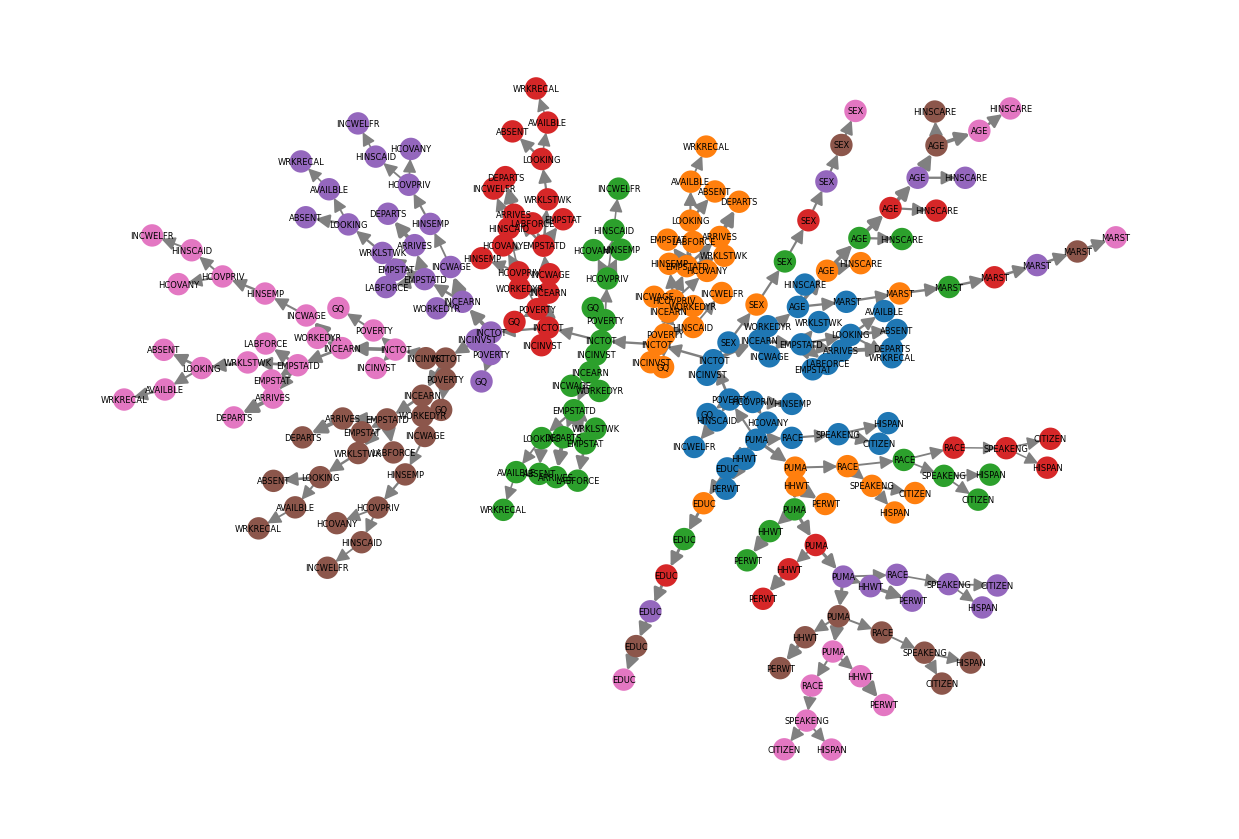

In [7]:
colors = list(mcolors.TABLEAU_COLORS.values())

plt.figure(dpi=200)
pos = graphviz_layout(graph, prog="neato")
width = [w ** .5 for w in nx.get_edge_attributes(graph, "weight").values()]
nx.draw(graph, pos=pos, width=width, edge_color="grey", node_color=[colors[n[1]-2012] for n in graph.nodes],
        node_size=50)
nx.draw_networkx_labels(graph, pos, labels={n:n[0] for n in nx.nodes(graph)}, font_size=3);

### 3.2 Computing the conditional distributions

100%|██████████████████████████████████████████| 237/237 [00:01<00:00, 204.69it/s]


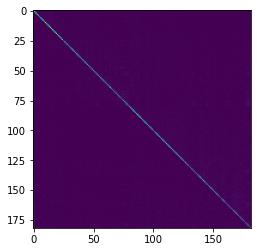

In [8]:
eps = 1
noise_scale = len(public_flat.columns) / n * eps

def compute_marginal_distribution(df, column, noise_scale: float = 0):
    marginal = df.groupby(column).size() / n

    # Only place where the data is accessed
    if noise_scale > 0:
        marginal += np.random.laplace(scale=noise_scale, size=marginal.size)
        marginal = marginal.clip(lower=0)
    return marginal / marginal.sum(axis=0)

def compute_conditional_distribution(df, column, parents, noise_scale: float = 0):
    joint = (df.groupby([column] + parents).size() / n)
    joint = joint.unstack(column, fill_value=0)
    
    # For some reason this is necessary (?)
    joint.columns = pd.Index([k[0] for k in joint.columns], name=str(column))
    
    if noise_scale > 0:
        joint += np.random.laplace(scale=noise_scale, size=joint.shape)
        joint = joint.clip(lower=0)
        
    return joint.div(joint.sum(axis=1), axis="rows")

def compute_bayesnet(df, cond, noise_scale: float = noise_scale):
    bayesnet = {}
    
    node = cond[0]
    *parents, root = node
    bayesnet[node] = compute_marginal_distribution(df, root, noise_scale)
    
    for node in tqdm(cond[1:]):
        *parents, column = node
        bayesnet[node] = compute_conditional_distribution(df, column, parents, noise_scale)
        
    return bayesnet
        
# This technique does not actually work, as any small amount of noise
# completely destroys the conditional distributions
bayesnet = compute_bayesnet(public_flat, cond, noise_scale=0)

plt.imshow(bayesnet[("PUMA", 2012), ("PUMA", 2013)].to_numpy())

Above, we plot the PUMA transitions between 2012 and 2013

### 3.3 Sampling from the first order bayesian network

In [9]:
def generate_sample(columns, cond, bayesnet, size=10):
    synthetic = pd.DataFrame(0, columns=columns, index=np.arange(size))
    
    # Sample the first column as i.i.d variables on the root node.
    node = cond[0]
    *parents, root = node
    dist = bayesnet[node]
    k = np.random.choice(a=len(dist), size=size, replace=True, p=dist.to_numpy())
    synthetic[root] = dist.index[k]
    # Conditional distributions
    for node in tqdm(cond[1:]):
        *parents, column = node
        dist = bayesnet[node]

        if len(parents) == 1:
            rows = synthetic[parents[0]]
            cumsum = dist.loc[rows].to_numpy().cumsum(axis=1)
        else:
            raise NotImplementedError()
            
        u = np.random.rand(size)
        k = (u[:, None] > cumsum).sum(axis=1)
        synthetic[column] = dist.columns[k]
        
    return synthetic

synthetic_flat = generate_sample(public_flat.columns, cond, bayesnet, size=len(public_flat))
synthetic_bin = sdnist.utils.stack(synthetic_flat)

synthetic = sdnist.utils.undo_discretize(synthetic_bin, sdnist.kmarginal.CensusKMarginalScore.BINS)
synthetic = synthetic.reindex(public.columns, axis=1).sort_values(["PUMA", "YEAR"])

synthetic

100%|███████████████████████████████████████████| 237/237 [00:07<00:00, 33.59it/s]


,PUMA,YEAR,HHWT,GQ,PERWT,SEX,AGE,MARST,RACE,HISPAN,...,WORKEDYR,INCTOT,INCWAGE,INCWELFR,INCINVST,INCEARN,POVERTY,DEPARTS,ARRIVES,sim_individual_id
539,17-1001,2012,80.0,1,80.0,2,45.0,1,1,0,...,3,55000.0,50000.0,0.0,0.0,50000.0,400.0,715.0,745.0,77
875,17-1001,2012,80.0,1,80.0,2,45.0,1,1,0,...,3,10000.0,10000.0,0.0,0.0,10000.0,80.0,715.0,715.0,125
1974,17-1001,2012,40.0,1,60.0,2,65.0,1,1,1,...,1,10000.0,0.0,0.0,0.0,0.0,60.0,0.0,0.0,282
2457,17-1001,2012,40.0,1,40.0,2,65.0,4,1,0,...,1,10000.0,0.0,0.0,0.0,0.0,80.0,0.0,0.0,351
3122,17-1001,2012,20.0,1,20.0,1,30.0,6,1,0,...,3,85000.0,85000.0,0.0,0.0,85000.0,501.0,915.0,915.0,446
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1177343,39-910,2018,20.0,1,20.0,2,60.0,6,1,0,...,3,100000.0,0.0,5000.0,0.0,100000.0,501.0,600.0,630.0,168191
1178043,39-910,2018,100.0,1,100.0,1,55.0,1,1,0,...,1,15000.0,0.0,0.0,0.0,0.0,501.0,0.0,0.0,168291
1182138,39-910,2018,140.0,1,160.0,1,35.0,4,1,0,...,3,80000.0,80000.0,0.0,0.0,80000.0,501.0,845.0,845.0,168876
1184966,39-910,2018,60.0,1,80.0,1,55.0,1,1,0,...,3,100000.0,100000.0,0.0,0.0,100000.0,501.0,645.0,730.0,169280


In [10]:
score = sdnist.kmarginal.CensusLongitudinalKMarginalScore(public, synthetic)
score.compute_score()

 10%|████▍                                       | 30/300 [00:00<00:03, 86.79it/s]/opt/homebrew/Caskroom/miniforge/base/envs/py39/lib/python3.9/site-packages/pandas/core/indexes/multi.py:3554: RuntimeWarning: The values in the array are unorderable. Pass `sort=False` to suppress this warning.
  result = lib.fast_unique_multiple([self._values, rvals], sort=sort)
100%|███████████████████████████████████████████| 300/300 [00:04<00:00, 71.09it/s]


493.97682178239444